In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_embeddings(folder_path):
    embeddings = []

    for file in Path(folder_path).glob("*.npy"):
        embedding = np.load(str(file))
        embedding = embedding.astype(np.float32)
        embeddings.append(embedding)
    return torch.tensor(np.array(embeddings[0])).to(device)

def load_embeddings_map(file_path):
    embeddings_map = []

    for file in Path(file_path).glob("*.csv"):
        df = pd.read_csv(file, header=None)
        embeddings_map.append(df.values.tolist())
    return pd.Series(embeddings_map[0])

folder_path = '../data/embeddings-train'
embeddings = load_embeddings(folder_path)
embeddings_map = load_embeddings_map(folder_path)
embeddings_map = embeddings_map.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings device: {embeddings.device}")
print(f"Embeddings map length: {len(embeddings_map)}")

Embeddings shape: torch.Size([10805, 512])
Embeddings device: cuda:0
Embeddings map length: 10805


In [2]:
import json
import numpy as np
from PIL import Image

def load_annotation(file_path):
    data = []

    with open (file_path, 'r', encoding="utf-8") as file:
        data = json.load(file)    
    return data

annotation_path = "../data/vimmsd-train.json"
image_folder_path = "../data/images/train-images"
data = load_annotation(annotation_path)

## Score Analysis

In [3]:
from sentence_transformers import SentenceTransformer, util
import torch

sarcasm_prompt = "sarcasm"
not_sarcasm_prompt = "not-sarcasm"

def map_clip_text_prompt(label):
    return sarcasm_prompt if (label=="sarcasm") else not_sarcasm_prompt

def map_test_label(label):
    return label if (label == "not-sarcasm") else "sarcasm"

def map_label(label):
    return 1 if (label== "sarcasm") else 0

def get_clip_cos_sim_score(image_embedding, text_model, label):
    text_embedding = text_model.encode(label, convert_to_tensor=True).to(device)
    image_embedding = image_embedding.to(device)
    score = util.cos_sim(text_embedding, image_embedding)
    return score[0].item()

def get_label(labels, text_model, image_embedding):
    result = []

    for i in range(len(labels)):
        label = labels[i]
        score = get_clip_cos_sim_score(image_embedding=image_embedding, text_model=text_model ,label=map_clip_text_prompt(label))
        result.append([label, score])
    result = sorted(result, key = lambda item: item[-1])
    return result[-1]

c:\Users\ADMIN\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels = ["sarcasm", "not-sarcasm"]
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32').to(device)

c:\Users\ADMIN\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
from sklearn import metrics
import matplotlib.pyplot as plt

labels = ["sarcasm"]
scores = []
labels_test = []
labels_predicted = []

for id in data:
    image_name = data[id]['image']
    label_test = map_test_label(data[id]['label'])
    
    embedding_id = embeddings_map.loc[embeddings_map == image_name].index
    result = get_label(labels, text_model, embeddings[embedding_id])
    label_predicted, score = result[0], result[1]
    labels_test.append(map_label(label_test))
    scores.append(score)
    labels_predicted.append(map_label(label_predicted))

c:\Users\ADMIN\anaconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [6]:
def get_stats(scores):
    print("Size: {}".format(len(scores)))
    print("Mean: {:.4f}".format(np.mean(scores)))
    print("Median: {:.4f}".format(np.median(scores)))
    print("STD: {:.4f}".format(np.std(scores)))
    print("Min: {:.4f}".format(np.min(scores)))
    print("Max: {:.4f}".format(np.max(scores)))
    print("Range: {:.4f}".format(np.ptp(scores)))
    print("Variance: {:.4f}".format(np.var(scores)))
    print("1st Quartile: {:.4f}".format(np.percentile(scores, 25)))
    print("2nd Quartile: {:.4f}".format(np.percentile(scores, 50)))
    print("3rd Quartile: {:.4f}".format(np.percentile(scores, 75)))

scores = np.array(scores)
labels_test = np.array(labels_test)

scores_sarcasm = scores[labels_test == 1]
scores_not_sarcasm = scores[labels_test == 0]

print("Prompt: {}".format(sarcasm_prompt), end="\n\n")
print("scores_sarcasm Stats")
get_stats(scores_sarcasm)
print()
print("scores_not_sarcasm Stats")
get_stats(scores_not_sarcasm)

Prompt: sarcasm

scores_sarcasm Stats
Size: 4743
Mean: 0.2077
Median: 0.2094
STD: 0.0212
Min: 0.1253
Max: 0.2745
Range: 0.1492
Variance: 0.0005
1st Quartile: 0.1939
2nd Quartile: 0.2094
3rd Quartile: 0.2231

scores_not_sarcasm Stats
Size: 6062
Mean: 0.1920
Median: 0.1916
STD: 0.0237
Min: 0.1032
Max: 0.2682
Range: 0.1651
Variance: 0.0006
1st Quartile: 0.1750
2nd Quartile: 0.1916
3rd Quartile: 0.2088


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def calculate_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tpr
    
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    return tpr, fpr, precision, recall, f1

fpr, tpr, thresholds = metrics.roc_curve(labels_test, scores)
roc_auc = metrics.auc(fpr, tpr)

f1_scores = []

for threshold in thresholds:
    _, _, _, _, f1 = calculate_metrics(labels_test, scores, threshold)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]
optimal_f1 = f1_scores[optimal_idx_f1]

optimal_idx_roc = np.argmin(np.sqrt((1 - tpr)**2 + fpr**2))
optimal_threshold_roc = thresholds[optimal_idx_roc]

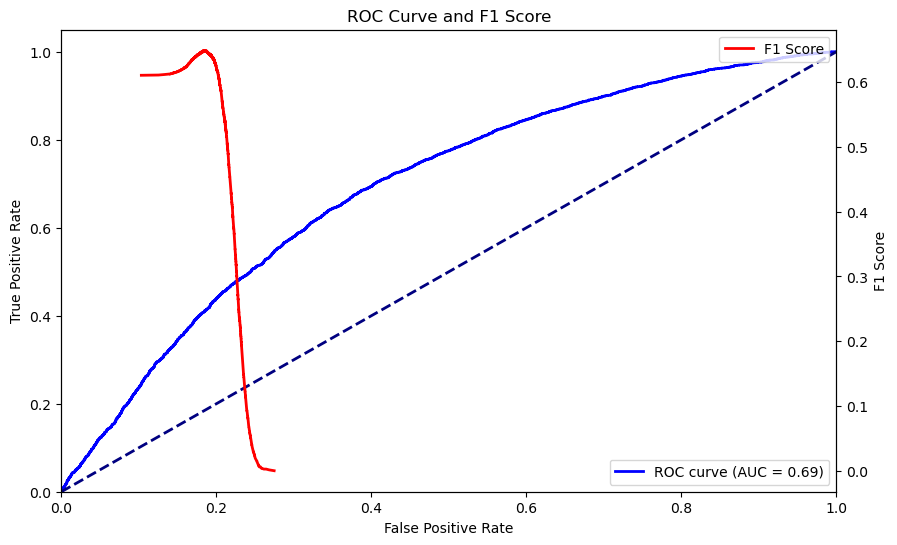

Optimal threshold (F1 Score): 0.1836
Optimal F1 Score: 0.6480
Optimal threshold (ROC): 0.1995

Metrics at F1 Score optimal threshold:
TPR: 0.8577, FPR: 0.6178, Precision: 0.5207, Recall: 0.8577, F1: 0.6480

Metrics at ROC optimal threshold:
TPR: 0.6738, FPR: 0.3764, Precision: 0.5834, Recall: 0.6738, F1: 0.6254


In [8]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

ax2.plot(thresholds, f1_scores, color='red', lw=2, label='F1 Score')
ax2.set_ylabel('F1 Score')
ax2.legend(loc="upper right")

plt.title('ROC Curve and F1 Score')
plt.show()

print(f"Optimal threshold (F1 Score): {optimal_threshold_f1:.4f}")
print(f"Optimal F1 Score: {optimal_f1:.4f}")
print(f"Optimal threshold (ROC): {optimal_threshold_roc:.4f}")

metrics_f1 = calculate_metrics(labels_test, scores, optimal_threshold_f1)
metrics_roc = calculate_metrics(labels_test, scores, optimal_threshold_roc)

print("\nMetrics at F1 Score optimal threshold:")
print(f"TPR: {metrics_f1[0]:.4f}, FPR: {metrics_f1[1]:.4f}, Precision: {metrics_f1[2]:.4f}, Recall: {metrics_f1[3]:.4f}, F1: {metrics_f1[4]:.4f}")

print("\nMetrics at ROC optimal threshold:")
print(f"TPR: {metrics_roc[0]:.4f}, FPR: {metrics_roc[1]:.4f}, Precision: {metrics_roc[2]:.4f}, Recall: {metrics_roc[3]:.4f}, F1: {metrics_roc[4]:.4f}")

## Confusion Metrics by scores

In [9]:
def get_label_by_score(prompt, image_embedding, text_model, threshold):
    score = get_clip_cos_sim_score(image_embedding=image_embedding, text_model=text_model, label=map_clip_text_prompt(prompt))
    if (score >= threshold):
        return ["sarcasm", score]
    else:
        return ["not-sarcasm", score]

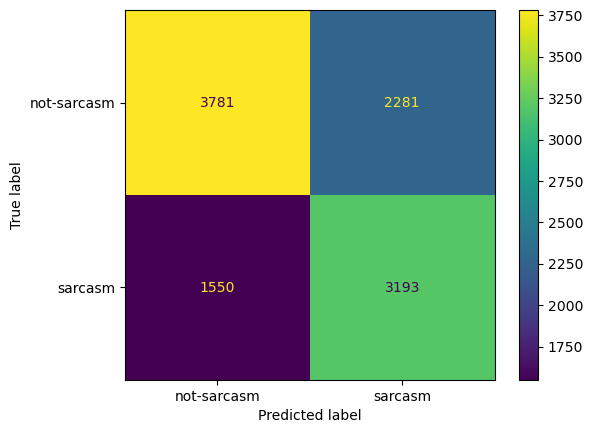

F1 score: 0.625
Precision score: 0.583
Recall score: 0.673


In [10]:
from sklearn import metrics
import matplotlib.pyplot as plt

threshold = 0.1995
prompt = "sarcasm"
labels_test = []
labels_predicted = []

for id in data:
    image_name = data[id]['image']
    label_test = map_test_label(data[id]['label'])
    embedding_id = embeddings_map.loc[embeddings_map == image_name].index

    result = get_label_by_score(prompt, embeddings[embedding_id], text_model, threshold)
    label_predicted, score = result[0], result[1]
    labels_test.append(map_label(label_test))
    labels_predicted.append(map_label(label_predicted))

confusion_matrix = metrics.confusion_matrix(y_pred=labels_predicted, y_true=labels_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not-sarcasm", "sarcasm"])
cm_display.plot()
plt.show()

f1 = metrics.f1_score(y_pred=labels_predicted, y_true=labels_test)
precision = metrics.precision_score(y_pred=labels_predicted, y_true=labels_test)
recall = metrics.recall_score(y_pred=labels_predicted, y_true=labels_test)
print("F1 score: {}".format(round(f1,3)))
print("Precision score: {}".format(round(precision,3)))
print("Recall score: {}".format(round(recall,3)))